# Cardiac Multi Atlas-Based Segmentation Example

## Import Modules

In [18]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from scipy.ndimage import measurements

%matplotlib inline

from platipy.imaging.tests.data import get_lung_nifti
from platipy.imaging.projects.cardiac.run import run_cardiac_segmentation
from platipy.imaging import ImageVisualiser
from platipy.imaging.label.utils import get_com

## Download Test Data

This will download lung cancer patient CT scans, with contours of several structures.
This only has to be done once - if it is ran again don't worry, the same data will not be downloaded again!

In [2]:
data_path = get_lung_nifti()

2021-05-11 02:47:13.299 | DEBUG    | platipy.imaging.tests.data:get_lung_nifti:58 - Output directory exists, stopping. data


## Configure Settings

We define the settings used for the end-to-end segmentation
Check out the guide in "PlatiPy-GettingStarted.pdf" for a description of these settings

In [3]:
settings = {
    "output_format": "Auto_{0}.nii.gz",
    "atlas_settings": {
        "atlas_id_list": ["101","102","103","104"],
        "atlas_structure_list": ["HEART","ESOPHAGUS","LUNG_L","LUNG_R","SPINALCORD"],
        "atlas_path": str(data_path),
        "atlas_image_format": "LCTSC-Test-S1-{0}/IMAGES/LCTSC_TEST_S1_{0}_0_CT_0.nii.gz",
        "atlas_label_format": "LCTSC-Test-S1-{0}/STRUCTURES/LCTSC_TEST_S1_{0}_0_RTSTRUCT_{1}.nii.gz",
        "crop_atlas_to_structures": False,
        "crop_atlas_expansion_mm": (10, 10, 10),
        "guide_structure_name": "HEART",
    },
    "auto_crop_target_image_settings": {
        "expansion_mm": [2, 2, 2],
    },
    "linear_registration_settings": {
        "reg_method": "similarity",
        "shrink_factors": [16, 8, 4],
        "smooth_sigmas": [0, 0, 0],
        "sampling_rate": 0.75,
        "default_value": -1024,
        "number_of_iterations": 50,
        "metric": "mean_squares",
        "optimiser": "gradient_descent_line_search",
        "verbose": False,
    },
    "deformable_registration_settings": {
        "isotropic_resample": True,
        "resolution_staging": [
            16,
            8,
            4,
        ],  # specify voxel size (mm) since isotropic_resample is set
        "iteration_staging": [15, 15, 15],
        "smoothing_sigmas": [4, 2, 1],
        "ncores": 8,
        "default_value": -1000,
        "verbose": False,
    },
    "structure_guided_registration_settings": {
        "isotropic_resample": True,
        "resolution_staging": [
            16,
            8,
            2,
        ],  # specify voxel size (mm) since isotropic_resample is set
        "iteration_staging": [25, 25, 25],
        "smoothing_sigmas": [0, 0, 0],
        "ncores": 8,
        "default_value": 0,
        "verbose": False,
    },
    "iar_settings": {
        "reference_structure": "HEART",
        "smooth_distance_maps": True,
        "smooth_sigma": 1,
        "z_score_statistic": "mad",
        "outlier_method": "iqr",
        "outlier_factor": 1.5,
        "min_best_atlases": 5,
        "project_on_sphere": False,
    },
    "label_fusion_settings": {
        "vote_type": "unweighted",
        "vote_params": {},  # No parameters needed for majority voting
        "optimal_threshold": {"HEART": 0.5, "ESOPHAGUS": 0.5, "LUNG_L": 0.5, "LUNG_R": 0.5, "SPINALCORD": 0.5},
    },
    "vessel_spline_settings": {
        "vessel_name_list": ["SPINALCORD"],
        "vessel_radius_mm_dict": {"SPINALCORD": 6},
        "scan_direction_dict": {"SPINALCORD": "z"},
        "stop_condition_type_dict": {"SPINALCORD": "count"},
        "stop_condition_value_dict": {"SPINALCORD": 1},
    },
    "return_as_cropped": False,
    'returnAsCropped': False
}

## Load Test Image

Read in the image we want to automatically segment


In [13]:
test_pat_path = data_path.joinpath("LCTSC-Test-S1-201")
test_image = sitk.ReadImage(str(test_pat_path.joinpath("IMAGES/LCTSC_TEST_S1_201_0_CT_0.nii.gz")))

## Run Auto-segmentation

This will take some time, and will print updates along the way


In [6]:
auto_structures = run_cardiac_segmentation(test_image, settings=settings)

2021-05-11 03:23:35.772 | INFO     | platipy.imaging.projects.cardiac.run:run_cardiac_segmentation:161 - 


KeyboardInterrupt: 

## Save segmentations
Optionally write the automatic segmentations to disk


In [16]:
output_name = settings["output_format"]
output_directory = test_pat_path.joinpath("SEGMENTATIONS")
output_directory.mkdir(exist_ok=True)

for struct_name in list(auto_structures.keys()):
    sitk.WriteImage(auto_structures[struct_name], str(output_directory.joinpath(output_name.format(struct_name))))

print(f"Segmentations saved to: {output_directory}")



Segmentations written to: data/LCTSC-Test-S1-201/SEGMENTATIONS


## Visualise Segmentations

Next, we can generate a nice figure to check what the segmentation looks like

The first step here is to convert SimpleITK images to NumPy arrays

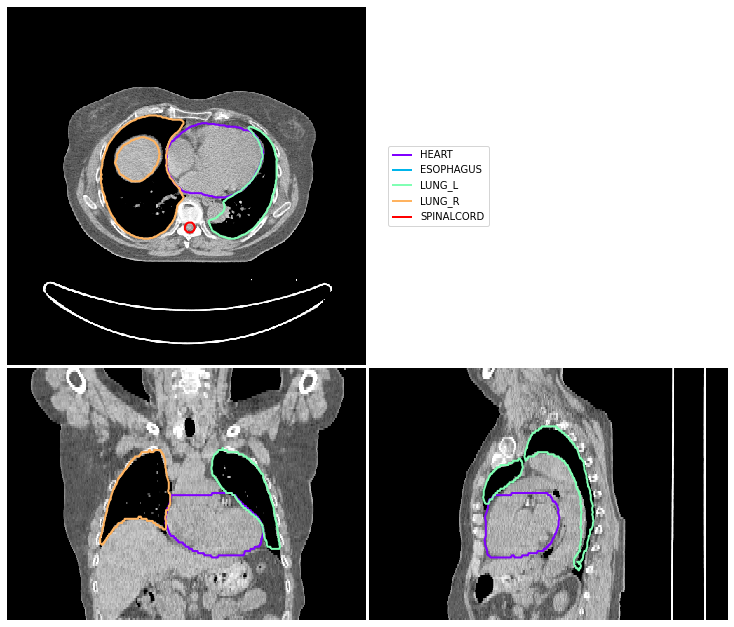

In [20]:
vis = ImageVisualiser(test_image, cut=get_com(auto_structures["HEART"]))

vis.add_contour({struct: auto_structures[struct] for struct in auto_structures.keys()})

fig = vis.show()